In [1]:
# libraries
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import random
import cv2
from threading import Thread
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import keras
import tensorflow as tf

from keras import models, layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-08-21 12:41:53.150939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 12:41:53.150986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 12:41:53.152509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images_path = '/kaggle/input/sign-language/KSL-dataset/Images'
test_path = '/kaggle/input/sign-language/KSL-dataset/Test.csv'
train_path = '/kaggle/input/sign-language/KSL-dataset/Train.csv'

# **Exploratory analysis of training dataset**
## 1.**Train data**

In [3]:
train_df = pd.read_csv(train_path)
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [4]:
# different classes of images

train_df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [5]:
train_df.shape

(6249, 2)

> Training images constitutes of 6,294 images  with 9 different classes.

**Sample images**

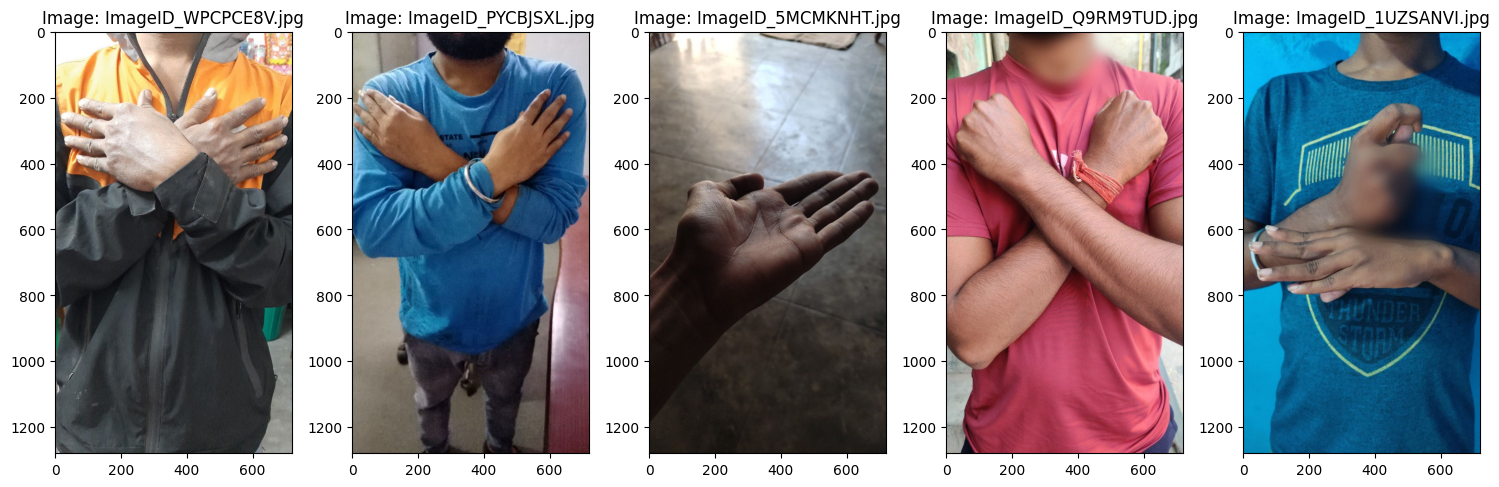

In [6]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
random_images = random.sample(images, 5)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('on')
plt.tight_layout()
plt.show()

From the sample visulization, all the images bearing different sign languages have varying sizes. Some images are larger widths or heights than the others.

**Image mapping to corresponding labels**

In [7]:
class KSL:
    def __init__(self, imgs_path, df, LR=1e-4, IMG_SIZE=256, BATCH_SIZE=32, EPOCHS=5):
        self.imgs_path = imgs_path
        self.df = df
        self.LR = LR
        self.IMG_SIZE = IMG_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.EPOCHS = EPOCHS
        
    def create_mapping(self):
        self.df['img_path'] = self.df['img_IDS'].apply(lambda x: os.path.join(self.imgs_path, f"{x}.jpg"))
        class_mapping = {label: idx for idx, label in enumerate(self.df['Label'].unique())}
        self.df['Encoded_Label'] = self.df['Label'].map(class_mapping)
        return self.df
 
    def crop_center(self, image, crop_size=(600, 600), target_size=(256, 256)):
        h, w, _ = image.shape
        crop_h, crop_w = crop_size

        start_x = (w - crop_w) // 2
        start_y = (h - crop_h) // 2

        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        resized_image = cv2.resize(cropped_image, target_size)
        
        img_yuv = cv2.cvtColor(resized_image, cv2.COLOR_RGB2YUV)
        img_y_channel = img_yuv[..., 0].astype(np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[..., 0] = clahe.apply(img_y_channel)
        
        equalized_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return equalized_image
    
    def plot_images_with_labels(self, num_images=5, crop_size=(600, 600), target_size=(256, 256)):
        df = self.create_mapping()
        plt.figure(figsize=(15, 10))
        sample_df = df.sample(num_images)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            img_path = row['img_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            resized_img = self.crop_center(img, crop_size=crop_size, target_size=target_size)
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(resized_img)
            plt.title(row["Label"])
            plt.axis('on')
        plt.tight_layout()
        plt.show()
        
    def process_ksl_images(self):
        df = self.create_mapping()
        
        def preprocessing_function(img):
            return self.crop_center(img, crop_size=(600, 600), target_size=(self.IMG_SIZE, self.IMG_SIZE))
        
        datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25, preprocessing_function=preprocessing_function)
        
        train_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="training",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        validation_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="validation",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        training_steps = train_images.n // train_images.batch_size
        validation_steps = validation_images.n // validation_images.batch_size
        
        return train_images, validation_images, training_steps, validation_steps
    
    def build_model(self, cnn_model):
        for layer in cnn_model.layers[:10]:
            layer.trainable = False
        x = cnn_model.output
        x = AveragePooling2D(pool_size=(4, 4))(x)
        x = Flatten(name='flatten')(x)
        x = Dense(9, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=cnn_model.input, outputs=x)
        model.compile(optimizer=Adam(learning_rate=self.LR), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
        
    def build_resnet50(self):
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(resnet_model)

    def build_inceptionv3(self):
        inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_model)

    def build_inception_resnet(self):
        inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_resnet)

    def build_vgg16(self):
        vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg16_model)

    def build_vgg19(self):
        vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg19_model)

    def build_densenet(self):
        densenet_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(densenet_model)
    
    def train_models(self):
        train_images, validation_images, training_steps, validation_steps = self.process_ksl_images()
        
        model_funcs = {
        'ResNet50': self.build_resnet50(),
        'InceptionV3': self.build_inceptionv3(),
        'InceptionResNetV2': self.build_inception_resnet(),
        'VGG16': self.build_vgg16(),
        'VGG19': self.build_vgg19(),
        'DenseNet121': self.build_densenet()
        }

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)

        histories = {}
        for model_name, cnn_model in model_funcs.items():
            print(f"Running {model_name}")
            history = cnn_model.fit(
                train_images,
                steps_per_epoch=training_steps,
                validation_data=validation_images,
                validation_steps=validation_steps,
                epochs=self.EPOCHS,
                callbacks=[reduce_lr]
            )
            histories[model_name] = history

        return histories
    
    def plot_metrics(self, histories):
        for model_name, history in histories.items():
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='train_accuracy')
            plt.plot(history.history['val_accuracy'], label='val_accuracy')
            plt.title(f'{model_name} Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='train_loss')
            plt.plot(history.history['val_loss'], label='val_loss')
            plt.title(f'{model_name} Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()



In [8]:
ksl = KSL(imgs_path=images_path, df=train_df)

In [9]:
# train models
histories = ksl.train_models()

Found 4687 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Running ResNet50
Epoch 1/5


I0000 00:00:1724244196.279180     292 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 143s 539ms/step - accuracy: 0.4418 - loss: 1.5982 - val_accuracy: 0.1094 - val_loss: 2.2635 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6562 - loss: 1.0102 - val_accuracy: 0.1538 - val_loss: 2.2429 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.9012 - loss: 0.3238 - val_accuracy: 0.1120 - val_loss: 2.5019 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.9688 - loss: 0.1325 - val_accuracy: 0.2308 - val_loss: 2.1804 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 328ms/step - accuracy: 0.9892 - loss: 0.0639 - val_accuracy: 0.1094 - val_loss: 2.8699 - learning_rate: 1.0000e-04
Running InceptionV3
Epoch 1/5
  1/146 ━━━━━━━━━━━━━━━━━━━━ 3:15:59 81s/step - accuracy: 0.1250 - loss: 2.3843

W0000 00:00:1724244460.479462     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4786 - loss: 1.4550

W0000 00:00:1724244541.808895     292 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 173s 636ms/step - accuracy: 0.4795 - loss: 1.4523 - val_accuracy: 0.6940 - val_loss: 0.8668 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.5938 - loss: 0.8405 - val_accuracy: 0.5000 - val_loss: 1.0745 - learning_rate: 1.0000e-04
Epoch 3/5


W0000 00:00:1724244562.457944     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 51s 334ms/step - accuracy: 0.8752 - loss: 0.3593 - val_accuracy: 0.7181 - val_loss: 0.8053 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.8125 - loss: 0.3894 - val_accuracy: 0.8462 - val_loss: 0.6105 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.9543 - loss: 0.1455 - val_accuracy: 0.7461 - val_loss: 0.8869 - learning_rate: 1.0000e-04
Running InceptionResNetV2
Epoch 1/5


W0000 00:00:1724244833.228223     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.4864 - loss: 1.3911

W0000 00:00:1724244983.890633     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.4874 - loss: 1.3883 - val_accuracy: 0.7578 - val_loss: 0.6737 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5938 - loss: 1.1005 - val_accuracy: 0.7308 - val_loss: 0.7800 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 69s 458ms/step - accuracy: 0.8822 - loss: 0.3205 - val_accuracy: 0.7604 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.9062 - loss: 0.2957 - val_accuracy: 0.7692 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.9698 - loss: 0.1053 - val_accuracy: 0.7630 - val_loss: 0.7517 - learning_rate: 1.0000e-04
Running VGG16
Epoch 1/5


2024-08-21 12:59:09.695659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-08-21 12:59:09.695707: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-08-21 12:59:09.695725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-08-21 12:59:09.695742: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.33366, expected 4.62762
2024-08-21 12:59:09.695756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.00267, expected 4.29663
2024-08-21 12:59:09.695767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 4.93559, expected 4.22954
2024-08-21 12:59:09.695785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.39283, expected 4.68678
2024-08-21 12:59:09.695796:

  1/146 ━━━━━━━━━━━━━━━━━━━━ 1:18:49 33s/step - accuracy: 0.0625 - loss: 2.4838

W0000 00:00:1724245176.697653     293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/146 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.1417 - loss: 2.2044

2024-08-21 12:59:49.597229: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.43987, expected 2.00293
2024-08-21 12:59:49.597285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.08335, expected 2.64642
2024-08-21 12:59:49.597301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.04435, expected 2.60742
2024-08-21 12:59:49.597331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2303: 3.03867, expected 2.60173
2024-08-21 12:59:49.597353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3584: 3.31627, expected 2.87933
2024-08-21 12:59:49.597371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4607: 2.83112, expected 2.39418
2024-08-21 12:59:49.597389: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5119: 3.27289, expected 2.83596
2024-08-21 12:59:49.597409: E external/l

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.2349 - loss: 2.0028

W0000 00:00:1724245228.194944     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 95s 431ms/step - accuracy: 0.2358 - loss: 2.0008 - val_accuracy: 0.5625 - val_loss: 1.1871 - learning_rate: 1.0000e-04
Epoch 2/5
  1/146 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.5938 - loss: 1.0258

2024-08-21 13:00:40.588991: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65715: 3.0157, expected 2.60987
2024-08-21 13:00:40.589402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131015: 2.86642, expected 2.46059
2024-08-21 13:00:40.589880: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196608: 2.23096, expected 1.76465
2024-08-21 13:00:40.589908: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196609: 3.31516, expected 2.84885
2024-08-21 13:00:40.589917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196610: 3.24272, expected 2.77641
2024-08-21 13:00:40.589926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196616: 3.59784, expected 3.13153
2024-08-21 13:00:40.589935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196629: 3.41196, expected 2.94565
2024-08-21 13:00:40.58

KeyboardInterrupt: 

In [ ]:
ksl.plot_metrics(histories)